## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

def calibratePinhole(chessboard_row, chessboard_col, filePaths):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboard_row*chessboard_col,3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_col,0:chessboard_row].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob(filePaths)
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chessboard_col,chessboard_row),None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    # Calibrate
    ret_calib, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    
    # Visualization
    for fname in images:
        img = cv2.imread(fname)
        
        # Undistort
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        # Draw and display the corners
        #undist = cv2.drawChessboardCorners(undist, (9,6), corners, ret)
        cv2.imshow('undist',undist)
        cv2.waitKey(500)
    
    cv2.destroyAllWindows()
    return mtx, dist


mtx, dist = calibratePinhole(6, 9, '../camera_cal/calibration*.jpg')

## And so on and so forth...

In [ ]:
import os

def abs_sobel_calculate(img, orient='x', kernel_size=None):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if(orient=='x'):
        if(kernel_size==None):
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        else:
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    elif(orient=='y'):
        if(kernel_size==None):
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        else:
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    else:
        raise Exception('Unknown orientation')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    return abs_sobel

def dir_calculate(img, sobel_kernel=3):
    # 1) Take the gradient in x and y separately
    abs_sobelx = abs_sobel_calculate(img, orient='x', kernel_size=sobel_kernel)
    abs_sobely = abs_sobel_calculate(img, orient='y', kernel_size=sobel_kernel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_img = np.arctan2(abs_sobely, abs_sobelx)
    return dir_img

def mask_threshold(img, thresh):
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def convertTo8bit(abs_img,max_value):
    res = np.uint8(255*abs_img/max_value)
    return res

def mag_calculate(img, sobel_kernel=3):
    # 2) Take the gradient in x and y separately
    abs_sobelx = abs_sobel_calculate(img, orient='x', kernel_size=sobel_kernel)
    abs_sobely = abs_sobel_calculate(img, orient='y', kernel_size=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.add(np.square(abs_sobelx), np.square(abs_sobely)))
    return abs_sobel

folderName = "../test_images/"
test_images = os.listdir(folderName)
for fileName in test_images:
    undist = cv2.undistort(cv2.imread(folderName + fileName), mtx, dist, None, mtx)
    fileName_without = fileName.split(".")
    B = undist[:,:,0]
    G = undist[:,:,1]
    R = undist[:,:,2]
    cv2.imwrite("../output_images/" + fileName_without[0] + "_1b." + fileName_without[1], B)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_1g." + fileName_without[1], G)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_1r." + fileName_without[1], R)
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    cv2.imwrite("../output_images/" + fileName_without[0] + "_2h." + fileName_without[1], H)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_2l." + fileName_without[1], L)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_2s." + fileName_without[1], S)
    #hsv = cv2.cvtColor(undist, cv2.COLOR_BGR2HSV)
    #H = hsv[:,:,0]
    #S = hsv[:,:,1]
    #V = hsv[:,:,2]
    #cv2.imwrite("../output_images/" + fileName_without[0] + "_3h." + fileName_without[1], H)
    #cv2.imwrite("../output_images/" + fileName_without[0] + "_3s." + fileName_without[1], S)
    #cv2.imwrite("../output_images/" + fileName_without[0] + "_3v." + fileName_without[1], V)
    # Run the function
    dir_binary = dir_calculate(undist, sobel_kernel=15)
    dir_binary = mask_threshold(dir_binary, (0.7, 1.3))
    dir_binary = convertTo8bit(dir_binary,1)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_4dir." + fileName_without[1], dir_binary)
    mag_binary = mag_calculate(undist, sobel_kernel=9)
    mag_binary = convertTo8bit(mag_binary,np.max(mag_binary))
    mag_binary = mask_threshold(mag_binary, (30, 100))
    mag_binary = convertTo8bit(mag_binary,1)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_5mag." + fileName_without[1], mag_binary)
    gradx = abs_sobel_calculate(undist, orient='x')
    grady = abs_sobel_calculate(undist, orient='y')
    gradx = convertTo8bit(gradx,np.max(gradx))
    grady = convertTo8bit(grady,np.max(grady))
    gradx = mask_threshold(gradx, (20, 100))
    grady = mask_threshold(grady, (20, 100))
    gradx = convertTo8bit(gradx,1)
    grady = convertTo8bit(grady,1)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_6gradx." + fileName_without[1], gradx)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_6grady." + fileName_without[1], grady)
    
    #experiment
    S_masked = mask_threshold(S, (150, 255))
    S_masked = convertTo8bit(S_masked,1)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_7smasked." + fileName_without[1], S_masked)
    
    # perspective transformation
    top_left = (557,475)
    top_right = (729,475)
    bottom_left = (253,697)
    bottom_right = (1069,697)
    cv2.circle(undist,top_left, 1,[0,0,255],-1)
    cv2.circle(undist,top_right, 1,[0,0,255],-1)
    cv2.circle(undist,bottom_left, 1,[0,0,255],-1)
    cv2.circle(undist,bottom_right, 1,[0,0,255],-1)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_ROI." + fileName_without[1], undist)
    src = np.float32([[top_left[0],top_left[1]],[top_right[0],top_right[1]],[bottom_left[0],bottom_left[1]],[bottom_right[0],bottom_right[1]]])
    # Define conversions in x and y from pixels space to meters
    dst = np.float32([[290,431],[990,431],[290,719],[990,719]]) # y = 24 pix/m, left to right = 700 pixel
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(S_masked, M, S_masked.shape[1::-1], flags=cv2.INTER_LINEAR)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_7warp." + fileName_without[1], warped)
    mag_warped = cv2.warpPerspective(mag_binary, M, mag_binary.shape[1::-1], flags=cv2.INTER_LINEAR)
    cv2.imwrite("../output_images/" + fileName_without[0] + "_5warp." + fileName_without[1], mag_warped)

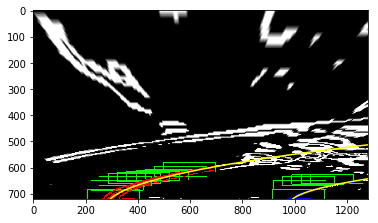

In [38]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

class sliding_window:
    def __init__(self,x_center,y_center,margin,window_height):
        self.x_center = x_center
        self.y_center = y_center
        self.margin = margin
        self.window_height = window_height
        
        self.win_y_low = int(y_center - int(window_height/2))
        self.win_y_high = int(y_center + int(window_height/2))
        self.win_x_low = int(x_center - margin)
        self.win_x_high = int(x_center + margin)
    
    def createSlidedWindow(self,slide_direction,margin,window_height):
        # Apply direction vector to the current window
        x_center = self.x_center + slide_direction[0]
        y_center = self.y_center + slide_direction[1]
        return sliding_window(x_center,y_center,margin,window_height)
    
    def isOutOfBound(self):
        if((self.win_y_low < 0) or (self.win_x_low < 0) or (self.win_x_high >= binary_warped.shape[1])):
            return True
        else:
            return False
    
    def visualize(self,out_img):
        if(not self.isOutOfBound()):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(self.win_x_low,self.win_y_low),
                          (self.win_x_high,self.win_y_high),(0,255,0), 2)
        return out_img
    
    def collectNonZeroInds(self,binary_warped):
        if(self.isOutOfBound()):
            return 0
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        self.nonzeroy = np.array(nonzero[0])
        self.nonzerox = np.array(nonzero[1])
        self.nonZeroInds = ((self.nonzeroy >= self.win_y_low) & (self.nonzeroy < self.win_y_high) & 
                            (self.nonzerox >= self.win_x_low) & (self.nonzerox < self.win_x_high)).nonzero()[0]
        return len(self.nonZeroInds)
    
    def getXmean(self):
        return np.mean(self.nonzerox[self.nonZeroInds])

# Load our image
#binary_warped = cv2.imread('../output_images/-00446_7warp.png')
binary_warped = cv2.imread('../output_images/-00966_5warp.png')
#binary_warped = cv2.imread('../output_images/test4_7warp.jpg')
binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)

def getLanePix(binary_warped,slided_windows):
    lane_inds = []
    for windows in slided_windows:
        lane_inds.append(windows.nonZeroInds)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    lane_inds = np.unique(np.concatenate(lane_inds))
    
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds]
    return x,y

def find_lane_pixels(binary_warped):
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    # Set height of windows - based on nwindows above and image shape
    window_height = 36
    
    # Take a histogram of the bottom of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]-window_height:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Derza
    initial_diff = window_height
    y_base = binary_warped.shape[0] - int(initial_diff/2)
    
    old_lefty = y_base + initial_diff
    old_righty = old_lefty
    
    left_failure_ctr = 0
    right_failure_ctr = 0
    
    # Derza
    slided_windows_left = []
    slided_windows_right = []
    
    # Current positions to be updated later for each window in nwindows
    left_window = sliding_window(leftx_base,y_base,margin,window_height)
    right_window = sliding_window(rightx_base,y_base,margin,window_height)

    # Step through the windows one by one
    while((len(slided_windows_left) < nwindows) and (len(slided_windows_right) < nwindows)):
        if(left_window.isOutOfBound() and right_window.isOutOfBound()):
            break
        
        # Draw the windows on the visualization image
        out_img = left_window.visualize(out_img)
        out_img = right_window.visualize(out_img)
        
        ### Identify the nonzero pixels in x and y within the window ###
        pix_num_left = left_window.collectNonZeroInds(binary_warped)
        pix_num_right = right_window.collectNonZeroInds(binary_warped)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        slide_direction_left = np.array([0.0,left_window.y_center - old_lefty]) # x,y
        slide_direction_right = np.array([0.0,right_window.y_center - old_righty]) # x,y
        
        if (pix_num_left > minpix):
            left_failure_ctr = 0
            slide_direction_left[0] = left_window.getXmean() - left_window.x_center
            if(len(slided_windows_left) < nwindows):
                slided_windows_left.append(left_window)
        else:
            left_failure_ctr += 1
            # recalculate histogram
            #hist_left = np.sum(binary_warped[left_window.win_y_low:left_window.win_y_high,:], axis=0)
            #leftx_candidate = np.argmax(hist_left[:midpoint])
            #good_left_inds_candidate = collectNonZeroPix(nonzerox,nonzeroy,int(leftx_candidate - margin),int(leftx_candidate + margin),
            #                                             win_yleft_low,win_yleft_high)
            #if (len(good_left_inds_candidate) > minpix):
            #    print("the other side is good left")
        
        if (pix_num_right > minpix):
            right_failure_ctr = 0
            slide_direction_right[0] = right_window.getXmean() - right_window.x_center
            if(len(slided_windows_right) < nwindows):
                slided_windows_right.append(right_window)
        else:
            right_failure_ctr += 1
            # recalculate histogram
            #hist_right = np.sum(binary_warped[right_window.win_y_low:right_window.win_y_high,:], axis=0)
            #right_window_c = sliding_window(np.argmax(hist_right[midpoint:]) + midpoint,right_window.y_center,
            #                                margin,window_height)
            #pix_num_right = right_window_c.collectNonZeroInds(binary_warped)
            #if (pix_num_right > minpix):
            #    slided_windows_right.append(right_window_c)
            #    out_img = right_window_c.visualize(out_img)
        
        # Calculate new direction in unit vector
        slide_direction_left = np.multiply(slide_direction_left,float(initial_diff)/np.linalg.norm(slide_direction_left))
        slide_direction_right = np.multiply(slide_direction_right,float(initial_diff)/np.linalg.norm(slide_direction_right))
        
        old_lefty = left_window.y_center
        old_righty = right_window.y_center
        
        # Apply direction vector to the current window
        left_window = left_window.createSlidedWindow(slide_direction_left,margin,window_height)
        right_window = right_window.createSlidedWindow(slide_direction_right,margin,window_height)
    
    # Extract left and right line pixel positions
    leftx,lefty = getLanePix(binary_warped,slided_windows_left)
    rightx,righty = getLanePix(binary_warped,slided_windows_right)

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img


out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)